In [1353]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.model_selection import cross_val_score, cross_validate

In [1354]:
df = pd.read_csv('../data/train.csv')
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1355]:
X= df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y= df['Survived']
X.shape,y.shape

((891, 7), (891,))

In [1356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #, random_state=56

In [1357]:
#X_train

data look clean, i.e. no weird values in there

In [1358]:
#X_train.isna().sum()

In [1359]:
numerical_columns = ['Age','Fare',]
categorical_columns = ['Embarked',] #'Pclass','Sex','SibSp','Parch',

In [1360]:
numerical_pipeline = Pipeline([
    ('numerical_imputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('num_scaler',StandardScaler()),
])

In [1361]:
categorical_pipeline = Pipeline([
    ('categorical_imputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('categorical_ohe',OneHotEncoder(sparse=False, handle_unknown='error',drop='first')),
])

In [1362]:
column_transformer = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline,['Age','Fare',]),
    ('categorical_pipeline',categorical_pipeline,['Pclass','Sex','SibSp','Embarked',]),
    #('num_discritazer',KBinsDiscretizer(n_bins=8, strategy='uniform'),['Age','Fare',]),#numerical_columns 
])

In [1363]:
column_transformer.fit(X_train) #learn how to do the transforamtion
X_train_fe = column_transformer.transform(X_train) #Do the accual transformation
X_test_fe = column_transformer.transform(X_test) #Do the same transformation on test set 

In [1364]:
X_train_fe[0].size

13

In [1385]:
m = LogisticRegression()
m.fit(X_train_fe,y_train) 
None

In [1366]:
ypred = m.predict(X_test_fe)

In [1367]:
accuracy_score(y_test,ypred) 

0.8324022346368715

In [1368]:
score =m.score(X_train_fe,y_train)

In [1369]:
m.score(X_test_fe,y_test)

0.8324022346368715

In [1370]:
precision = precision_score(y_test,ypred)
recall = recall_score(y_test,ypred)

print(f'Precision = {precision:.4f} \nRecall = {recall:.4f}')

Precision = 0.7857 
Recall = 0.7097


In [1371]:
scores = cross_val_score(m, X_train_fe, y_train, cv=10)
scores.round(3)

array([0.819, 0.792, 0.761, 0.831, 0.746, 0.789, 0.789, 0.873, 0.775,
       0.732])

In [1372]:
f"Mean cross-validation score: {scores.mean(): 5.3f}"

'Mean cross-validation score:  0.791'

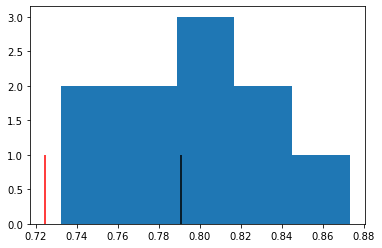

In [1384]:
plt.hist(scores, bins=5) #it doesn't add much value for low ks
plt.vlines(scores.mean(),ymin=0,ymax=1, color='black')
plt.vlines(score,ymin=0,ymax=1, color='red') # this is the model score
None

In [1374]:
from sklearn.utils import resample
from tqdm import tqdm # progress bar

In [1375]:
boots = []
split_size = int(len(X_train_fe)*0.75)
for i in tqdm(range(1000)):
    Xb, yb = resample(X_train_fe, y_train) #bootsrapping random resample
    Xb_train = Xb[:split_size] #train data
    yb_train = yb[:split_size]
    Xb_test = Xb[split_size:] # validation data
    yb_test = yb[split_size:]
    m.fit(Xb_train, yb_train) #fit on the train data
    score = m.score(Xb_test, yb_test) # score on the val data
    boots.append(score) # save the score
boots.sort() # sort scores from best to worst - required for my confidence interval levels

100%|██████████| 1000/1000 [00:16<00:00, 61.61it/s]


In [1376]:
ci80 = boots[100:-100]
print(f"80% confidence interval: {ci80[0]} to {ci80[-1]}")

80% confidence interval: 0.7584269662921348 to 0.8370786516853933


In [1377]:
ci90 = boots[50:-50]
print("90% confidence interval: {} to {}".format(ci90[0], ci90[-1]))

90% confidence interval: 0.7471910112359551 - 0.848314606741573


In [1378]:
ci99 = boots[5:-5]
print("99% confidence interval: {} to {}".format(ci99[0], ci99[-1]))

99% confidence interval: 0.7191011235955056 - 0.8707865168539326


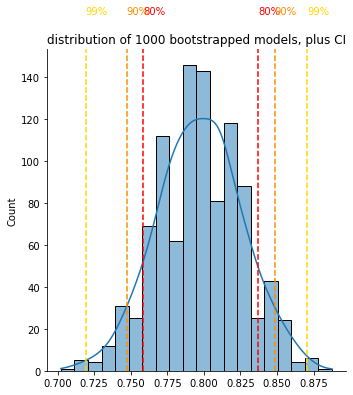

In [1383]:
import seaborn as sns
sns.displot(boots, bins=20, kde=True)
plt.axvline(x=ci80[0], color = 'red', linestyle = '--')
plt.axvline(x=ci80[-1], color = 'red', linestyle = '--')
plt.axvline(x=ci90[0], color = 'darkorange', linestyle = '--')
plt.axvline(x=ci90[-1], color = 'darkorange', linestyle = '--')
plt.axvline(x=ci99[0], color = 'gold', linestyle = '--')
plt.axvline(x=ci99[-1], color = 'gold', linestyle = '--')
plt.text(s = '80%', x=ci80[0], y = 170, color = 'red')
plt.text(s = '90%', x=ci90[0], y = 170, color = 'darkorange')
plt.text(s = '99%', x=ci99[0], y = 170, color = 'gold')
plt.text(s = '80%', x=ci80[-1], y = 170, color = 'red')
plt.text(s = '90%', x=ci90[-1], y = 170, color = 'darkorange')
plt.text(s = '99%', x=ci99[-1], y = 170, color = 'gold')
plt.title('distribution of 1000 bootstrapped models, plus CI')
None # just does not write the anoying line

In [1380]:
X_test_kaggle = pd.read_csv('../data/test.csv')
X_test_kaggle.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1381]:
X_test_kaggle_fe = column_transformer.transform(X_test_kaggle[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']])

In [1382]:
#Ups... how can I test?